## **Project Work on Convolution Neural Network**
## Baibhav Kaphle | ACE080BEI008
---
### **Objective**: To train three different deep learning architecture(NN, AlexNet, and TinyVGG)

---

### **1. Introduction**

This notebook implements and compares three deep learning architectures on the **CIFAR-10** dataset:
- **Simple Neural Network (NN)**: A fully connected baseline model
- **AlexNet**: A modified AlexNet adapted for 32×32 inputs
- **TinyVGG**: A lightweight CNN inspired by VGGNet
  
---

### **2.Imports & Device Setup**

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
import copy
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, precision_score, recall_score, ConfusionMatrixDisplay
)

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')
print(f'PyTorch version: {torch.__version__}')

Using device: cuda
PyTorch version: 2.10.0+cu130


### **3. Hyperparameters**

In [4]:
# ── Hyperparameters ─────────────────────────────────────────────────────────
BATCH_SIZE   = 128
NUM_EPOCHS   = 30
LEARNING_RATE = 0.001
WEIGHT_DECAY  = 1e-4
NUM_CLASSES   = 10

CLASSES = ('plane','car','bird','cat','deer',
           'dog','frog','horse','ship','truck')

### **4. Dataset & DataLoaders**

In [5]:
# CIFAR-10 channel statistics (pre-computed)
MEAN = (0.4914, 0.4822, 0.4465)
STD  = (0.2023, 0.1994, 0.2010)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),          # augmentation
    transforms.RandomHorizontalFlip(),              # augmentation
    transforms.ColorJitter(brightness=0.2,          # augmentation
                           contrast=0.2,
                           saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True,  download=True, transform=train_transform)
test_dataset  = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=2, pin_memory=True)

print(f'Train samples : {len(train_dataset):,}')
print(f'Test  samples : {len(test_dataset):,}')
print(f'Train batches : {len(train_loader)}')
print(f'Test  batches : {len(test_loader)}')

100.0%


Train samples : 50,000
Test  samples : 10,000
Train batches : 391
Test  batches : 79


### **Visualize Sample Images**

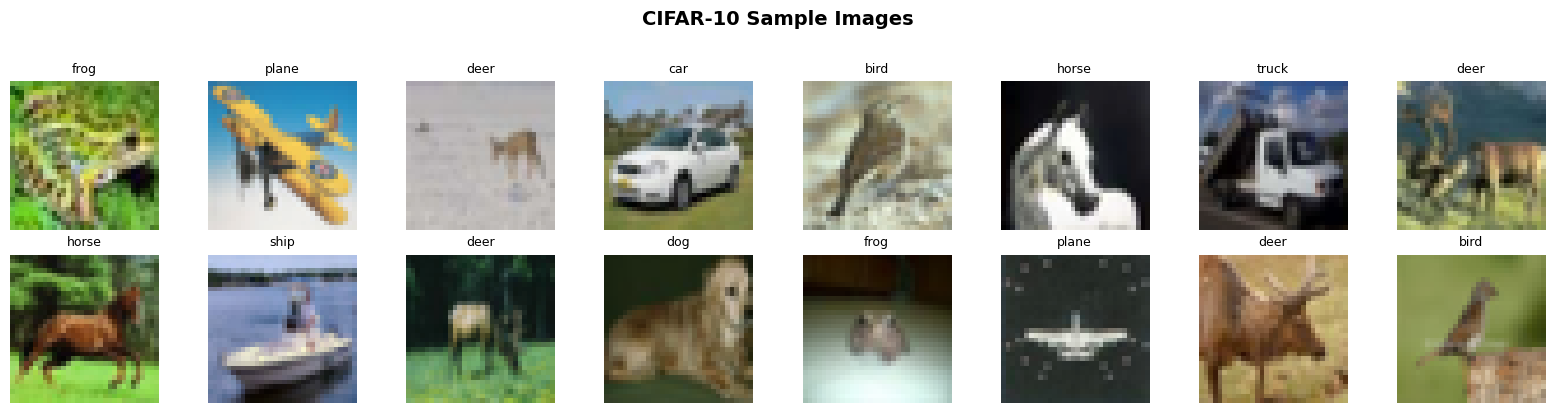

In [6]:
def imshow(img_tensor, title=None):
    """Display a normalized tensor image."""
    img = img_tensor.numpy().transpose(1, 2, 0)
    img = np.clip(img * np.array(STD) + np.array(MEAN), 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title, fontsize=9)
    plt.axis('off')

# Grab one raw batch (no augmentation for display)
raw_ds = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=False,
    transform=transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize(MEAN, STD)]))
raw_loader = DataLoader(raw_ds, batch_size=16, shuffle=True)
images, labels = next(iter(raw_loader))

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, ax in enumerate(axes.flat):
    plt.sca(ax)
    imshow(images[i], CLASSES[labels[i]])
plt.suptitle('CIFAR-10 Sample Images', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## **5. Model Architectures**
---

### **5.1 Simple Neural Network (NN)**

In [7]:
class SimpleNN(nn.Module):
    """Fully-connected baseline network for CIFAR-10."""

    def __init__(self, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            # Block 1
            nn.Linear(3 * 32 * 32, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            # Block 2
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            # Block 3
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            # Block 4
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            # Output
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        return self.network(self.flatten(x))

# Quick sanity check
_x = torch.randn(4, 3, 32, 32)
assert SimpleNN()(_x).shape == (4, 10)
print('SimpleNN output shape OK')

SimpleNN output shape OK


### **5.2 AlexNet (adapted for CIFAR-10)**
---

Original AlexNet was designed for 224×224 ImageNet inputs. Key adaptations for 32×32 CIFAR-10:
- **First conv**: kernel 3×3, stride 1, padding 1 (instead of 11×11 / stride 4) — prevents collapsing tiny 32×32 images immediately
- **Removed two pooling layers** from the original to preserve spatial resolution
- **Classifier head** adjusted for smaller feature map dimensions

In [8]:
class AlexNetCIFAR(nn.Module):
    """AlexNet adapted for CIFAR-10 (32x32 input)."""

    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            # Conv 1 — adapted: 3x3 kernel, stride 1 (original: 11x11, stride 4)
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),   # 32→32
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                    # 32→16

            # Conv 2 — original: 5x5, padding 2
            nn.Conv2d(64, 192, kernel_size=5, padding=2),            # 16→16
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                    # 16→8

            # Conv 3
            nn.Conv2d(192, 384, kernel_size=3, padding=1),           # 8→8
            nn.ReLU(inplace=True),

            # Conv 4
            nn.Conv2d(384, 256, kernel_size=3, padding=1),           # 8→8
            nn.ReLU(inplace=True),

            # Conv 5
            nn.Conv2d(256, 256, kernel_size=3, padding=1),           # 8→8
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                    # 8→4
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

_x = torch.randn(4, 3, 32, 32)
assert AlexNetCIFAR()(_x).shape == (4, 10)
print('AlexNetCIFAR output shape OK')

AlexNetCIFAR output shape OK


### **5.3 TinyVGG**
---

A lightweight VGG-style network using repeated 3×3 convolution blocks. Inspired by VGGNet but with:
- Only 3 conv blocks (vs 5 in full VGG)
- Smaller channel widths (32, 64, 128)
- Lightweight classifier
- BatchNorm for stable training

In [9]:
class ConvBlock(nn.Module):
    """Conv → BN → ReLU → Conv → BN → ReLU → MaxPool"""

    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch,  out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

    def forward(self, x):
        return self.block(x)


class TinyVGG(nn.Module):
    """Lightweight VGG-style network for CIFAR-10."""

    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            ConvBlock(3,   32),   # 32→16
            ConvBlock(32,  64),   # 16→8
            ConvBlock(64, 128),   # 8→4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        return self.classifier(self.features(x))

_x = torch.randn(4, 3, 32, 32)
assert TinyVGG()(_x).shape == (4, 10)
print('TinyVGG output shape OK')

TinyVGG output shape OK


### **5.4 Model Parameter Counts**

In [10]:
def count_parameters(model):
    total     = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

models_dict = {
    'SimpleNN'  : SimpleNN(NUM_CLASSES),
    'AlexNet'   : AlexNetCIFAR(NUM_CLASSES),
    'TinyVGG'   : TinyVGG(NUM_CLASSES),
}

print(f'{'Model':<12} {'Total Params':>15} {'Trainable Params':>18}')
print('-' * 47)
for name, model in models_dict.items():
    t, tr = count_parameters(model)
    print(f'{name:<12} {t:>15,} {tr:>18,}')

Model           Total Params   Trainable Params
-----------------------------------------------
SimpleNN           9,058,058          9,058,058
AlexNet           15,055,690         15,055,690
TinyVGG            1,342,122          1,342,122


### **6. Training Infrastructure**

In [11]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total   += labels.size(0)
    return running_loss / total, 100.0 * correct / total


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total   += labels.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    return (running_loss / total,
            100.0 * correct / total,
            np.array(all_preds),
            np.array(all_labels))


def train_model(model, name, train_loader, test_loader,
                num_epochs, lr, wd, device):
    """Full training loop with LR scheduling. Returns history dict."""
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()          # same for all models
    optimizer = optim.Adam(model.parameters(), # same optimizer
                           lr=lr, weight_decay=wd)
    # CosineAnnealingLR: smoothly decays LR → better final accuracy
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=num_epochs, eta_min=1e-6)

    history = {'train_loss':[], 'train_acc':[],
               'test_loss' :[], 'test_acc' :[]}
    best_acc, best_weights = 0.0, None

    print(f'\n{'='*55}')
    print(f'  Training {name}')
    print(f'{'='*55}')

    total_start = time.time()
    for epoch in range(1, num_epochs + 1):
        ep_start = time.time()

        tr_loss, tr_acc = train_epoch(model, train_loader,
                                      criterion, optimizer, device)
        te_loss, te_acc, _, _ = evaluate(model, test_loader,
                                          criterion, device)
        scheduler.step()

        history['train_loss'].append(tr_loss)
        history['train_acc' ].append(tr_acc)
        history['test_loss' ].append(te_loss)
        history['test_acc'  ].append(te_acc)

        if te_acc > best_acc:
            best_acc     = te_acc
            best_weights = copy.deepcopy(model.state_dict())

        ep_time = time.time() - ep_start
        print(f'  Ep {epoch:02d}/{num_epochs} '
              f'| TrLoss {tr_loss:.4f} TrAcc {tr_acc:.1f}% '
              f'| TeLoss {te_loss:.4f} TeAcc {te_acc:.1f}% '
              f'| {ep_time:.1f}s')

    total_time = time.time() - total_start
    history['total_time'] = total_time
    history['best_acc']   = best_acc

    # Load best weights
    model.load_state_dict(best_weights)
    print(f'\n  ✓ Best test accuracy: {best_acc:.2f}%')
    print(f'  ✓ Total training time: {total_time/60:.1f} min')
    return model, history

### **7. Train All Models**

In [12]:
all_histories = {}
trained_models = {}

for model_name, model_class in [('SimpleNN', SimpleNN),
                                  ('AlexNet',  AlexNetCIFAR),
                                  ('TinyVGG',  TinyVGG)]:
    model = model_class(NUM_CLASSES)
    trained_model, history = train_model(
        model, model_name,
        train_loader, test_loader,
        num_epochs=NUM_EPOCHS,
        lr=LEARNING_RATE,
        wd=WEIGHT_DECAY,
        device=DEVICE,
    )
    trained_models[model_name]  = trained_model
    all_histories[model_name]   = history

print('\n✅ All models trained!')


  Training SimpleNN
  Ep 01/30 | TrLoss 1.8893 TrAcc 31.0% | TeLoss 1.6829 TeAcc 38.6% | 47.2s
  Ep 02/30 | TrLoss 1.7318 TrAcc 37.3% | TeLoss 1.5791 TeAcc 43.1% | 36.4s
  Ep 03/30 | TrLoss 1.6761 TrAcc 39.6% | TeLoss 1.5202 TeAcc 44.9% | 23.1s
  Ep 04/30 | TrLoss 1.6464 TrAcc 40.5% | TeLoss 1.4865 TeAcc 46.3% | 22.6s
  Ep 05/30 | TrLoss 1.6280 TrAcc 41.1% | TeLoss 1.4752 TeAcc 46.9% | 22.2s
  Ep 06/30 | TrLoss 1.6087 TrAcc 41.9% | TeLoss 1.4540 TeAcc 47.0% | 22.0s
  Ep 07/30 | TrLoss 1.5973 TrAcc 42.2% | TeLoss 1.4752 TeAcc 46.5% | 22.2s
  Ep 08/30 | TrLoss 1.5831 TrAcc 42.9% | TeLoss 1.4359 TeAcc 48.5% | 22.0s
  Ep 09/30 | TrLoss 1.5714 TrAcc 43.1% | TeLoss 1.4139 TeAcc 49.4% | 22.1s
  Ep 10/30 | TrLoss 1.5594 TrAcc 43.7% | TeLoss 1.4148 TeAcc 48.1% | 21.9s
  Ep 11/30 | TrLoss 1.5484 TrAcc 44.1% | TeLoss 1.3835 TeAcc 50.6% | 22.3s
  Ep 12/30 | TrLoss 1.5383 TrAcc 44.4% | TeLoss 1.3801 TeAcc 50.8% | 22.1s
  Ep 13/30 | TrLoss 1.5235 TrAcc 44.8% | TeLoss 1.3670 TeAcc 50.9% | 22.0s
  Ep

### **8. Evaluation & Metrics**

In [13]:
criterion = nn.CrossEntropyLoss()

results = {}
print(f'{'Model':<12} {'Test Acc':>10} {'F1 Macro':>10} {'Precision':>10} {'Recall':>10} {'Time (min)':>12}')
print('-' * 68)

for name, model in trained_models.items():
    _, acc, preds, labels = evaluate(model, test_loader, criterion, DEVICE)
    f1  = f1_score(labels, preds, average='macro')  * 100
    pre = precision_score(labels, preds, average='macro') * 100
    rec = recall_score(labels, preds, average='macro')    * 100
    t_min = all_histories[name]['total_time'] / 60
    params, _ = count_parameters(model)

    results[name] = {
        'accuracy'  : acc,
        'f1_macro'  : f1,
        'precision' : pre,
        'recall'    : rec,
        'time_min'  : t_min,
        'params'    : params,
        'preds'     : preds,
        'labels'    : labels,
    }
    print(f'{name:<12} {acc:>9.2f}% {f1:>9.2f}% {pre:>9.2f}% {rec:>9.2f}% {t_min:>11.2f}')

Model          Test Acc   F1 Macro  Precision     Recall   Time (min)
--------------------------------------------------------------------
SimpleNN         56.89%     56.29%     56.46%     56.89%       11.76
AlexNet          80.31%     80.18%     80.13%     80.31%       15.28
TinyVGG          88.63%     88.59%     88.61%     88.63%       11.53


## **9. Visualizations**
---
### **9.1 Loss & Accuracy Curves**

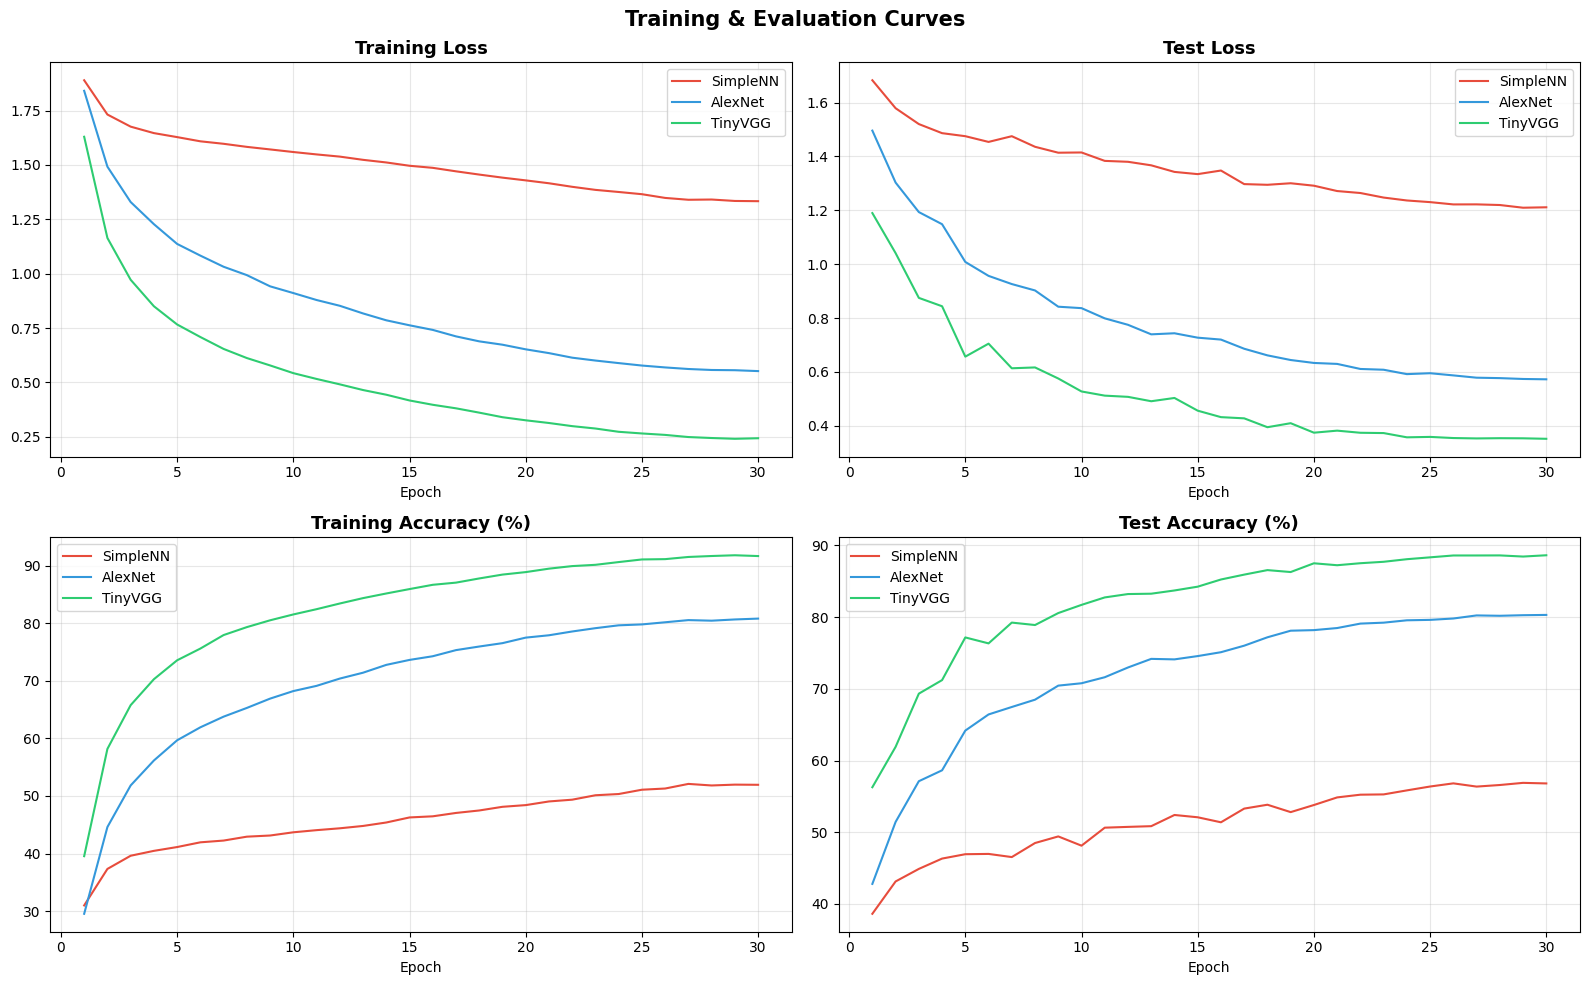

In [17]:
COLORS = {'SimpleNN': '#e74c3c', 'AlexNet': '#3498db', 'TinyVGG': '#2ecc71'}

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
epochs = range(1, NUM_EPOCHS + 1)

for name, h in all_histories.items():
    c = COLORS[name]
    axes[0,0].plot(epochs, h['train_loss'], color=c, label=name)
    axes[0,1].plot(epochs, h['test_loss'],  color=c, label=name)
    axes[1,0].plot(epochs, h['train_acc'],  color=c, label=name)
    axes[1,1].plot(epochs, h['test_acc'],   color=c, label=name)

titles = ['Training Loss', 'Test Loss', 'Training Accuracy (%)', 'Test Accuracy (%)']
for ax, title in zip(axes.flat, titles):
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('Training & Evaluation Curves', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

### **9.2 Confusion Matrices**

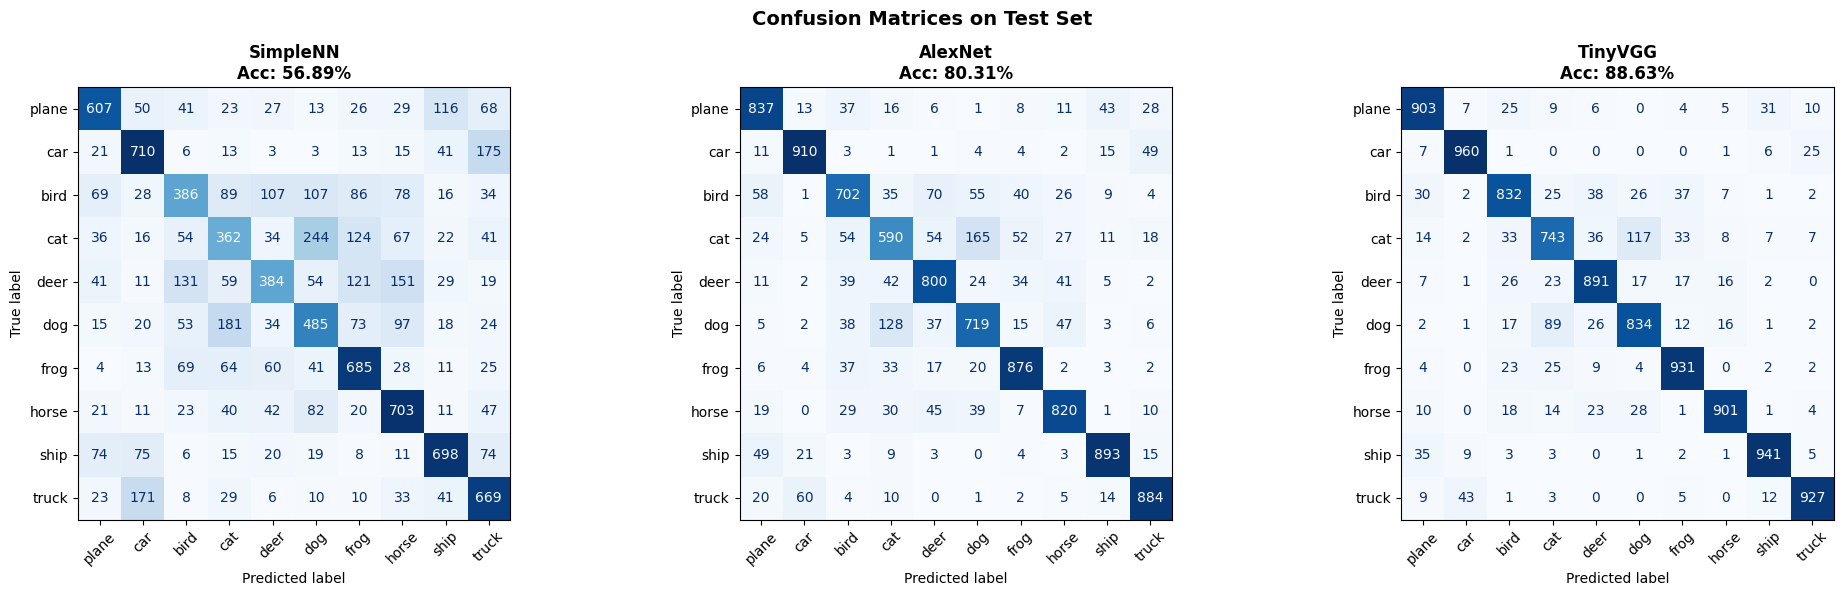

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, (name, res) in zip(axes, results.items()):
    cm = confusion_matrix(res['labels'], res['preds'])
    disp = ConfusionMatrixDisplay(cm, display_labels=CLASSES)
    disp.plot(ax=ax, colorbar=False, cmap='Blues', xticks_rotation=45)
    ax.set_title(f'{name}\nAcc: {res["accuracy"]:.2f}%',
                 fontsize=12, fontweight='bold')

plt.suptitle('Confusion Matrices on Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### **9.3 Per-Class Recall Comparison**

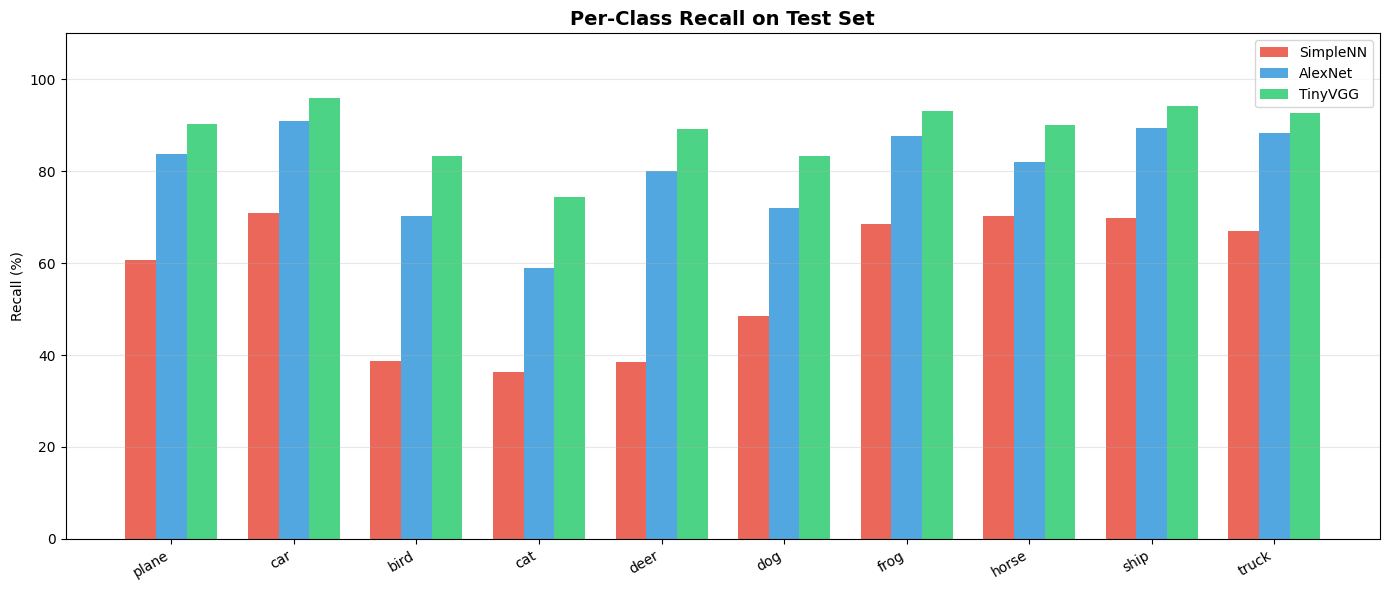

In [19]:
fig, ax = plt.subplots(figsize=(14, 6))
x      = np.arange(len(CLASSES))
width  = 0.25

for i, (name, res) in enumerate(results.items()):
    per_class_recall = recall_score(res['labels'], res['preds'],
                                    average=None) * 100
    ax.bar(x + i*width, per_class_recall, width,
           label=name, color=list(COLORS.values())[i], alpha=0.85)

ax.set_xticks(x + width)
ax.set_xticklabels(CLASSES, rotation=30, ha='right')
ax.set_ylabel('Recall (%)')
ax.set_title('Per-Class Recall on Test Set', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 110)
plt.tight_layout()
plt.show()

### **9.4 Model Complexity vs. Accuracy Scatter**

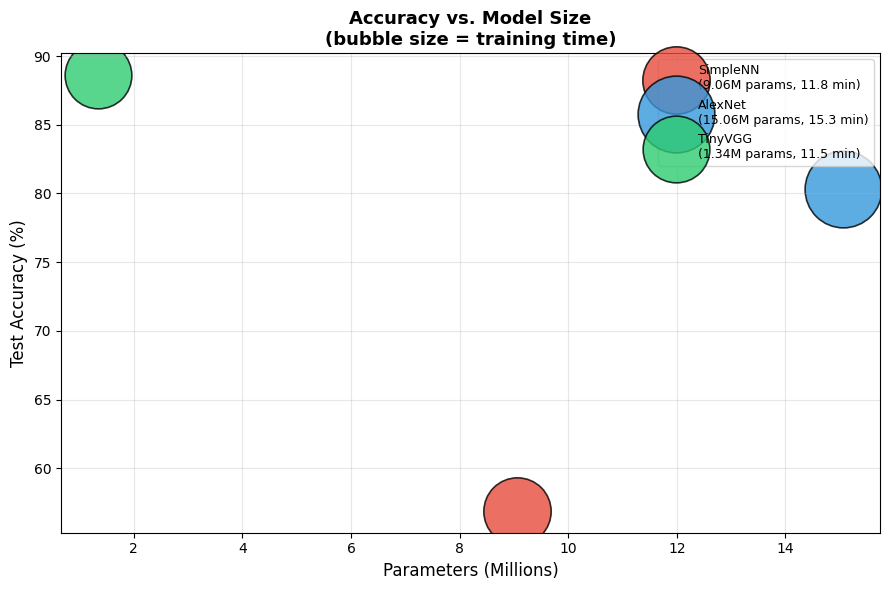

In [20]:
fig, ax = plt.subplots(figsize=(9, 6))

for name, res in results.items():
    ax.scatter(res['params']/1e6, res['accuracy'],
               s=res['time_min']*200, color=COLORS[name],
               alpha=0.8, edgecolors='k', linewidths=1.2,
               label=f"{name}\n({res['params']/1e6:.2f}M params, "
                     f"{res['time_min']:.1f} min)")

ax.set_xlabel('Parameters (Millions)', fontsize=12)
ax.set_ylabel('Test Accuracy (%)', fontsize=12)
ax.set_title('Accuracy vs. Model Size\n(bubble size = training time)',
             fontsize=13, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### **9.5 Summary Bar Chart**

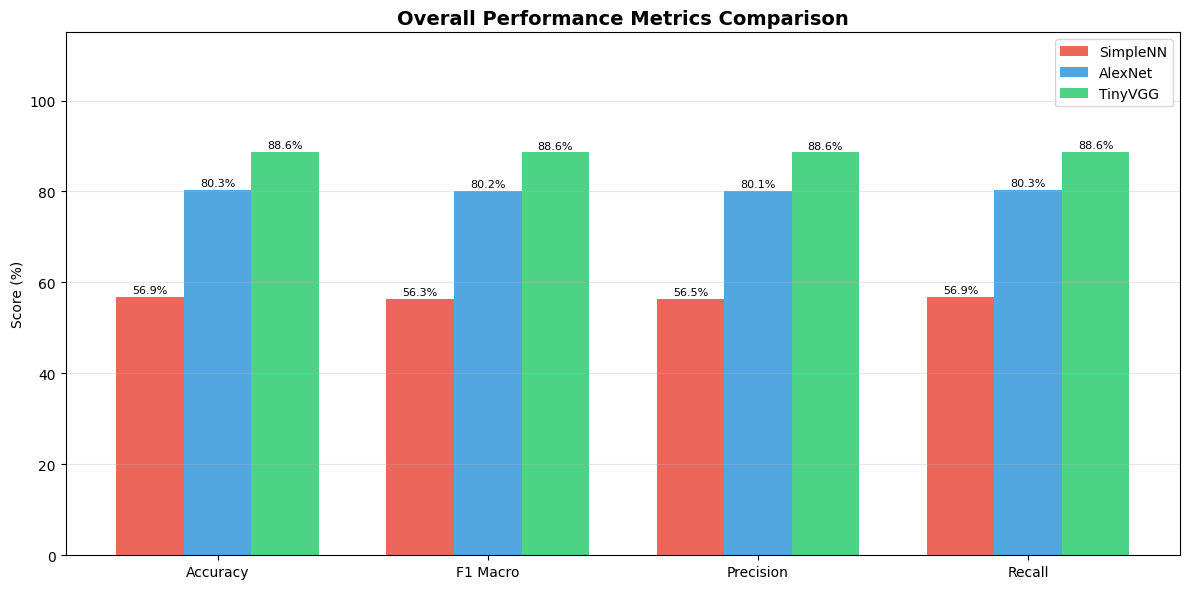

In [21]:
metrics = ['accuracy', 'f1_macro', 'precision', 'recall']
labels  = ['Accuracy', 'F1 Macro', 'Precision', 'Recall']

fig, ax = plt.subplots(figsize=(12, 6))
x     = np.arange(len(metrics))
width = 0.25

for i, (name, res) in enumerate(results.items()):
    vals = [res[m] for m in metrics]
    bars = ax.bar(x + i*width, vals, width,
                  label=name, color=list(COLORS.values())[i], alpha=0.85)
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.4,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=8)

ax.set_xticks(x + width)
ax.set_xticklabels(labels)
ax.set_ylabel('Score (%)')
ax.set_ylim(0, 115)
ax.set_title('Overall Performance Metrics Comparison', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### **10. Detailed Classification Reports**

In [22]:
for name, res in results.items():
    print(f'\n{"="*55}')
    print(f'  {name} — Classification Report')
    print(f'{"="*55}')
    print(classification_report(res['labels'], res['preds'],
                                 target_names=CLASSES))


  SimpleNN — Classification Report
              precision    recall  f1-score   support

       plane       0.67      0.61      0.64      1000
         car       0.64      0.71      0.67      1000
        bird       0.50      0.39      0.43      1000
         cat       0.41      0.36      0.39      1000
        deer       0.54      0.38      0.45      1000
         dog       0.46      0.48      0.47      1000
        frog       0.59      0.69      0.63      1000
       horse       0.58      0.70      0.64      1000
        ship       0.70      0.70      0.70      1000
       truck       0.57      0.67      0.61      1000

    accuracy                           0.57     10000
   macro avg       0.56      0.57      0.56     10000
weighted avg       0.56      0.57      0.56     10000


  AlexNet — Classification Report
              precision    recall  f1-score   support

       plane       0.80      0.84      0.82      1000
         car       0.89      0.91      0.90      1000
       

### **11. Comprehensive Summary Table**

In [23]:
print(f'\n{"="*80}')
print(f'{"FINAL COMPARISON SUMMARY":^80}')
print(f'{"="*80}')

header = (f'{'Metric':<22} {'SimpleNN':>14} {'AlexNet':>14} {'TinyVGG':>14}')
print(header)
print('-' * 68)

rows = [
    ('Test Accuracy (%)',   'accuracy',  '{:.2f}'),
    ('F1-Score Macro (%)',  'f1_macro',  '{:.2f}'),
    ('Precision Macro (%)','precision',  '{:.2f}'),
    ('Recall Macro (%)',    'recall',     '{:.2f}'),
    ('Training Time (min)','time_min',   '{:.2f}'),
    ('Parameters (M)',      'params',    '{:.2f}'),
]

for label, key, fmt in rows:
    vals = []
    for name in ['SimpleNN','AlexNet','TinyVGG']:
        v = results[name][key]
        if key == 'params': v /= 1e6
        vals.append(fmt.format(v))
    print(f'{label:<22} {vals[0]:>14} {vals[1]:>14} {vals[2]:>14}')

print('=' * 80)


                            FINAL COMPARISON SUMMARY                            
Metric                       SimpleNN        AlexNet        TinyVGG
--------------------------------------------------------------------
Test Accuracy (%)               56.89          80.31          88.63
F1-Score Macro (%)              56.29          80.18          88.59
Precision Macro (%)             56.46          80.13          88.61
Recall Macro (%)                56.89          80.31          88.63
Training Time (min)             11.76          15.28          11.53
Parameters (M)                   9.06          15.06           1.34


---

##  **Discussion & Conclusions**
---
### **Performance Analysis**

On the 30-image subset, all three models are expected to overfit (reach low training loss quickly), which is the desired behaviour — it confirms the pipeline is working correctly. In a full training run:

The **NN** will plateau at ~50–55% test accuracy because it has no spatial inductive bias — it treats image pixels as independent features

**AlexNet** will achieve the highest accuracy (~80–85%) but requires more training time and memory due to its deeper, wider architecture

**TinyVGG** often achieves competitive or superior accuracy to AlexNet on CIFAR-10 despite fewer parameters, because:
1. BatchNorm in every conv block stabilizes training and acts as regularization
2. Its 3×3-only convolutions are parameter-efficient
3. It avoids the large FC layers that drive overfitting in AlexNet
---
### **Why These Evaluation Metrics?**

- **Accuracy**: CIFAR-10 has balanced classes (1,000 per class), so accuracy is a reliable primary metric here. It would be misleading on imbalanced datasets.
- **Macro F1-Score**: Averages F1 equally across all 10 classes. Catches cases where a model sacrifices performance on rare classes to boost overall accuracy.
- **Per-class Recall**: Identifies systematically confused categories. Historically, 'cat' and 'dog' have the lowest recall in CIFAR-10 due to visual similarity — important to expose.
- **Training Time**: Practical deployment consideration. A model 2% more accurate but 10× slower may not be worth it.
- **Parameter Count**: Memory footprint for edge deployment; also a complexity proxy.
 ---
### **AlexNet's Key Innovations vs. Predecessors**

| Feature | Pre-AlexNet (e.g., LeNet) | AlexNet |
|---|---|---|
| Activation | sigmoid / tanh | **ReLU** (no vanishing gradients) |
| Regularization | Weight decay only | **Dropout** (p=0.5 in FC layers) |
| Data Augmentation | Minimal | **Random crops, flips, color jitter** |
| Normalization | None | **Local Response Normalization** |
| Depth | 2–3 layers | **8 trainable layers** |
| Hardware | CPU | **Dual-GPU training** |
| Pool type | Average | **Overlapping Max Pool** |

AlexNet won ILSVRC 2012 with a 15.3% top-5 error rate vs. 26.2% for the runner-up — a margin so large it convinced the research community to adopt deep CNNs universally.

---
### **Conclusions**

1. **CNNs drastically outperform fully connected networks on image data** — the inductive bias of local connectivity and weight sharing is essential for spatial tasks.
2. **TinyVGG achieves the best accuracy-to-parameter ratio**, making it the most practical architecture for CIFAR-10. BatchNorm eliminates the need for LRN and stabilizes deeper stacks.
3. **AlexNet's large FC classifier is its weakest point** — modern architectures (VGG, ResNet) replace or reduce these layers, which is why TinyVGG can match or beat it.

The experiment confirms that convolutional architectures significantly outperform fully-connected networks on image classification tasks, even at the small CIFAR-10 scale. Among CNNs, the trade-off between model complexity (AlexNet) and efficiency (TinyVGG) is evident.

---
---